In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from scipy.stats import stats 

from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings('ignore')
plt.rcParams['font.family']='Microsoft YaHei' 

# import toad

D:\Anaconda3\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [24]:
loan=pd.read_csv("cs-training.csv")
loan=loan.drop(['Unnamed: 0'],axis=1)

In [25]:
loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 11 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      150000 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 2   age                                   150000 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 4   DebtRatio                             150000 non-null  float64
 5   MonthlyIncome                         120269 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 7   NumberOfTimes90DaysLate               150000 non-null  int64  
 8   NumberRealEstateLoansOrLines          150000 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 10  NumberOfDependents                    146076 non-null  float64
dtype

#### 字段解释

In [5]:
# SeriousDlqin2yrs	借款人是否逾期90天或更长时间	标签（Y/N）	Label
# RevolvingUtilizationOfUnsecuredLines	无担保信贷额度除以总额度	百分比	RevolvingRatio
# age	借款人年龄	整型	Age
# NumberOfTime30-59DaysPastDueNotWorse	借款人过去两年逾期在30-59天的次数	整型	30-59D
# DebtRatio	每月的负债比率	百分比	DebtRatio
# MonthlyIncome	月收入	浮点型	MonthlyIncome
# NumberOfOpenCreditLinesAndLoans	未结贷款（如车贷或抵押贷款等）和信用额度（如信用卡）的数量	整型	OpenL
# NumberOfTimes90DaysLate	借款人已逾期90天以上的次数	整型	90D
# NumberRealEstateLoansOrLines	抵押和房地产贷款（包括房屋净值信用额度）	整型	RealEstate
# NumberOfTime60-89DaysPastDueNotWorse	借款人过去两年逾期在60-89天的次数	整型	60-89D
# NumberOfDependents	除本人以外的家属人数（配偶、子女等）	整型	Dependents

In [26]:
loan.columns=['Label', 'RevolvingRatio', 'Age', '30-59D', 'DebtRatio', 'MonthlyIncome',
                'OpenL', '90D', 'RealEstate', '60-89D', 'Dependents'] 

## 2. 数据预处理

### 2.1 缺失值预处理

#### 2.1.1 字符型变量
* （1）利用众数填充;  
* （2）缺失数据占比较少，直接删除所在行数据；  
* （3）缺失数据占比较多，直接删除该变量；  
* （4）可不做处理，分箱时可单独作为一个箱体。

#### 2.1.2 数值型变量
* （1）利用均值/众数填充；  
* （2）利用模型预测值填充；  
* （3）缺失数据占比较少，直接删除所在行数据；  
* （4）缺失数据占比较多，直接删除该变量；

In [7]:
loan.describe()
# MonthlyIncome与Dependents有缺失值

,Label,RevolvingRatio,Age,30-59D,DebtRatio,MonthlyIncome,OpenL,90D,RealEstate,60-89D,Dependents
count,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,1.202690e+05,150000.000000,150000.000000,150000.000000,150000.000000,146076.000000
mean,0.066840,6.048438,52.295207,0.421033,353.005076,6.670221e+03,8.452760,0.265973,1.018240,0.240387,0.757222
std,0.249746,249.755371,14.771866,4.192781,2037.818523,1.438467e+04,5.145951,4.169304,1.129771,4.155179,1.115086
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.029867,41.000000,0.000000,0.175074,3.400000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.154181,52.000000,0.000000,0.366508,5.400000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,0.559046,63.000000,0.000000,0.868254,8.249000e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,1.000000,50708.000000,109.000000,98.000000,329664.000000,3.008750e+06,58.000000,98.000000,54.000000,98.000000,20.000000


In [8]:
# 查看数据缺失情况
missing=loan.isnull().sum().sort_values(ascending=False).reset_index()
missing.columns=['feature','miss_num']
missing['miss_rate']=missing['miss_num']/loan.shape[0]
missing

,feature,miss_num,miss_rate
0,MonthlyIncome,29731,0.198207
1,Dependents,3924,0.026160
2,Label,0,0.000000
3,RevolvingRatio,0,0.000000
4,Age,0,0.000000
5,30-59D,0,0.000000
6,DebtRatio,0,0.000000
7,OpenL,0,0.000000
8,90D,0,0.000000
9,RealEstate,0,0.000000


* MonthlyIncome为家庭月收入，连续型数值变量，可用均值或者模型预测值填充缺失值  

In [9]:
# - - - - - - - 1、利用均值填充 - - - - - - -
# loan['MonthlyIncome'].fillna(loan['MonthlyIncome'].mean(),inplace=True)

In [10]:
# - - - - - - - 2、利用模型预测值填充 - - - - - - -

# 选取MonthlyIncome和其他非缺失变量作为训练模型数据
income=loan.iloc[:,[5,1,2,3,4,6,7,8,9]]

# MonthlyIncome非空作为训练集
income_train=income.loc[income['MonthlyIncome'].notnull()]
# MonthlyIncome为空作为测试集
income_test=income.loc[income['MonthlyIncome'].isnull()]

# MonthlyIncome作为模型因变量，其他非缺失变量作为模型自变量
X=income_train.iloc[:,1:]
Y=income_train.iloc[:,0]

RFR=RandomForestRegressor(random_state=0,n_estimators=200,max_depth=3,n_jobs=-1)
RFR.fit(X,Y)

income_pred=RFR.predict(income_test.iloc[:,1:])
loan.loc[loan['MonthlyIncome'].isnull(),'MonthlyIncome']=income_pred

*  Dependents为家属人数，数值型变量，用众数填充缺失值

In [11]:
loan['Dependents'].fillna(loan['Dependents'].mode()[0],inplace=True)

### 2.2 异常值预处理

#### 2.2.1 字符型变量
* （1）异常数据占比较少，直接删除所在行数据；    
* （2）利用均值/众数填充；  
* （3）可不做处理，分箱时可单独作为一个箱体。  

#### 2.2.2 数值型变量
* （1）异常数据占比较少，直接删除所在行数据；  
* （2）利用均值/众数填充；   
* （3）可不做处理，利用分箱可将异常值包含在内

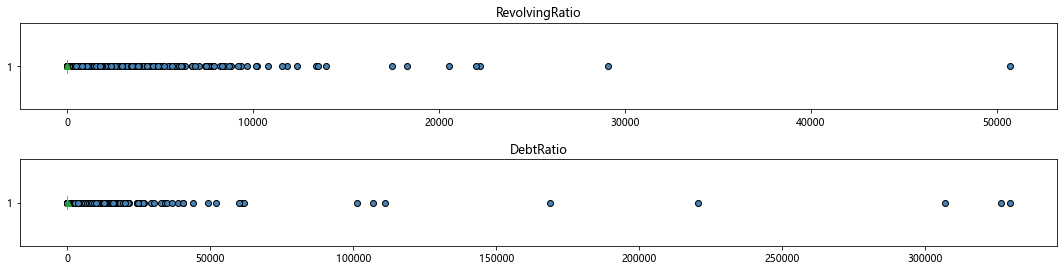

In [12]:
fig=plt.figure(figsize=(15,4))
ax1=fig.add_subplot(211)
ax1.boxplot(loan['RevolvingRatio'],vert=False,showmeans=True,flierprops = {"marker":"o","markerfacecolor":"steelblue"})
ax1.set_title('RevolvingRatio')

ax2=fig.add_subplot(212)
ax2.boxplot(loan['DebtRatio'],vert=False,showmeans=True,flierprops = {"marker":"o","markerfacecolor":"steelblue"})
ax2.set_title('DebtRatio')

plt.tight_layout(pad=1.5)
plt.show()

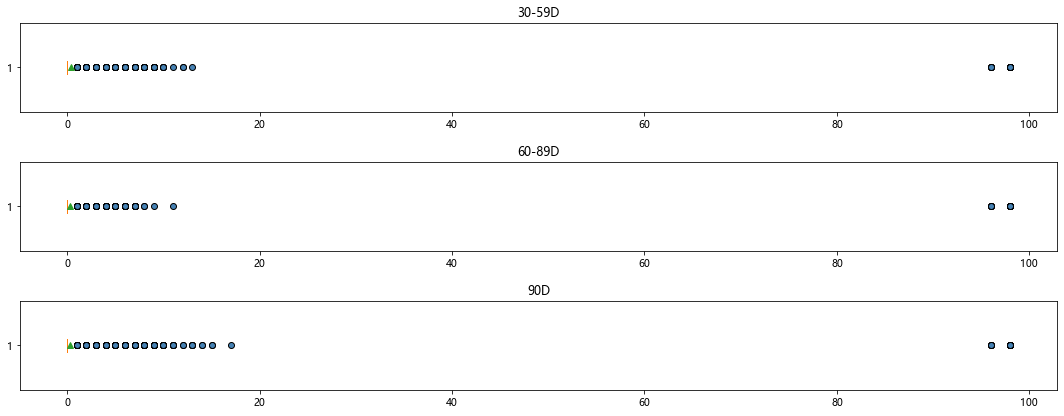

In [13]:
fig=plt.figure(figsize=(15,6))
ax1=fig.add_subplot(311)
ax1.boxplot(loan['30-59D'],vert=False,showmeans=True,flierprops = {"marker":"o","markerfacecolor":"steelblue"})
ax1.set_title('30-59D')

ax2=fig.add_subplot(312)
ax2.boxplot(loan['60-89D'],vert=False,showmeans=True,flierprops = {"marker":"o","markerfacecolor":"steelblue"})
ax2.set_title('60-89D')

ax3=fig.add_subplot(313)
ax3.boxplot(loan['90D'],vert=False,showmeans=True,flierprops = {"marker":"o","markerfacecolor":"steelblue"})
ax3.set_title('90D')

plt.tight_layout(pad=1.5)
plt.show()

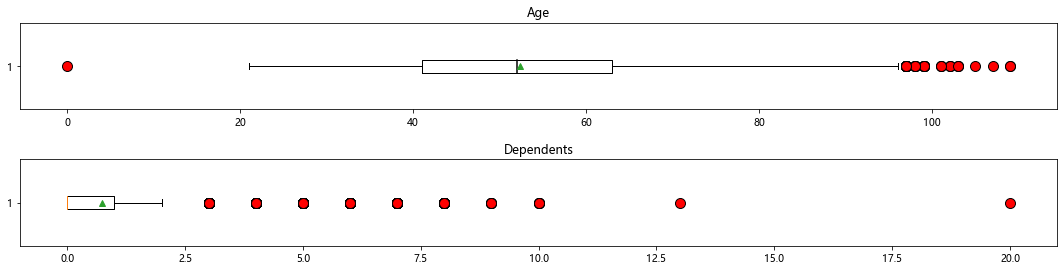

In [14]:
fig=plt.figure(figsize=(15,4))
ax1=fig.add_subplot(211)
ax1.boxplot(loan['Age'],vert=False
            ,showmeans=True
#             ,showbox=True
            ,meanprops={'color': 'blue', 'linewidth': '1.5'}
            ,medianprops={'color': 'black', 'linewidth': '1.5'}
            ,flierprops={"marker": "o", "markerfacecolor": "red", "markersize": 10})
ax1.set_title('Age')

ax2=fig.add_subplot(212)
ax2.boxplot(loan['Dependents']
            ,vert=False
            ,showmeans=True
            ,flierprops={"marker": "o", "markerfacecolor": "red", "markersize": 10})
ax2.set_title('Dependents')

plt.tight_layout(pad=1.5)
plt.show()

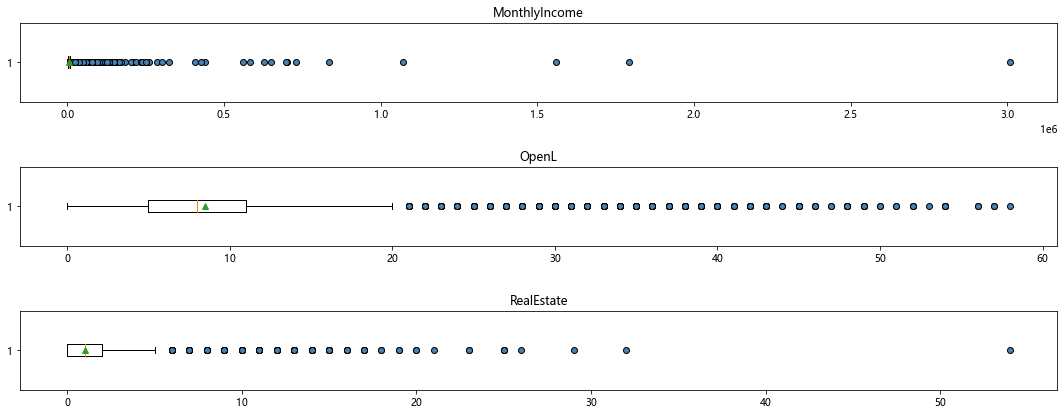

In [15]:
fig=plt.figure(figsize=(15,6))
ax1=fig.add_subplot(311)
ax1.boxplot(loan['MonthlyIncome'],vert=False,showmeans=True,flierprops = {"marker":"o","markerfacecolor":"steelblue"})
ax1.set_title('MonthlyIncome')

ax2=fig.add_subplot(312)
ax2.boxplot(loan['OpenL'],vert=False,showmeans=True,flierprops = {"marker":"o","markerfacecolor":"steelblue"})
ax2.set_title('OpenL')

ax3=fig.add_subplot(313)
ax3.boxplot(loan['RealEstate'],vert=False,showmeans=True,flierprops = {"marker":"o","markerfacecolor":"steelblue"})
ax3.set_title('RealEstate')

plt.tight_layout(pad=1.5)
plt.show()

## 3. 相关性分析

<AxesSubplot:>

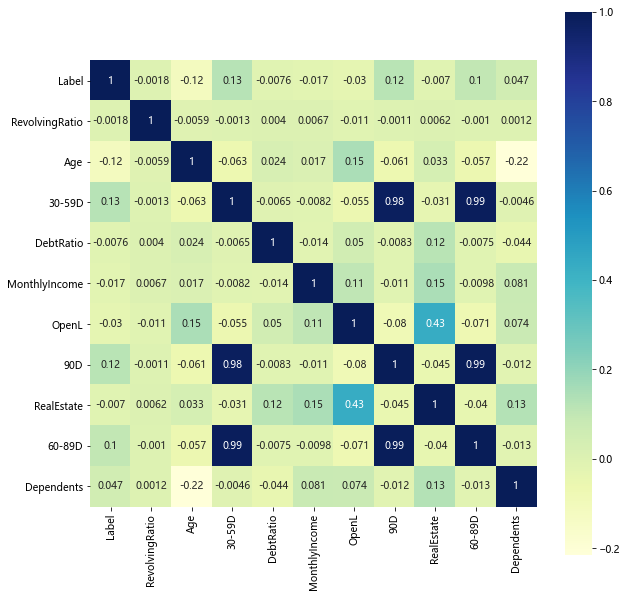

In [16]:
feature=loan.columns[:]
feature=list(feature)
corr=loan[feature].corr()

plt.figure(figsize=(10,10))
sns.heatmap(corr,square=True,annot=True,cmap="YlGnBu")

In [17]:
# 变量30-59D、60-89D、90D三个直接的相关性很高，根据业务理解可将三个变量相加合成一个变量预期30天以上的次数
# loan['D30']=loan['30-59D']+loan['60-89D']+loan['90D']

In [18]:
loan1=loan.drop(['30-59D','60-89D','90D'],axis=1)

## 4. 数据分箱

In [19]:
# 计算WOE和IV

def cal_woe(Y,X,bins):
    """ 计算卡方值
    Args:
        Y: 标签值
        X：变量值
        bins: 变量X的分箱
    Returns:
        result,woe,iv
    """
    
    total_bad = Y.sum()    # 总的坏样本数
    total_good = Y.count() - total_bad   # 总的好样本数
    
    df = pd.DataFrame({'X':X, 'Y':Y, 'bins':pd.cut(X,bins)})

    #分组计算好坏样本数
    bad=df.query("Y==1").groupby('bins')['Y'].count().reset_index(name='badnum')
    good=df.query("Y==0").groupby('bins')['Y'].count().reset_index(name='goodnum')

    result=pd.merge(bad,good,on='bins')


    result['badrate'] = result['badnum'] / total_bad
    result['goodrate'] = result['goodnum'] / total_good
    result['woe'] = np.log(result['goodrate'] / result['badrate'])
    result['iv']=(result['goodrate'] - result['badrate']) * result['woe']
    iv = result['iv'].sum()

    # woe值列表
    woe = list(result['woe'])
    
#     print("变量{0}的iv值为：{1}".format(X.name,round(iv,2)))
    
    plt.figure(figsize=(8,6))
    plt.bar(range(result.shape[0]),result['woe'],tick_label=result['bins'],label='WOE')
    plt.title("{0}(iv={1})".format(X.name,round(iv,2)))
    plt.xticks(rotation=30)
    plt.rc('legend', fontsize=10)
    plt.legend(loc='best')
    plt.show()
    
    return result,woe,iv

### 4.1 卡方分箱

基于卡方检验的连续变量最优分箱，实现步骤如下：  
* （1）给定连续变量 V，对V中的值进行排序，然后每个元素值单独一组，完成初始化阶段；  
* （2）对相邻的组，两两计算卡方值；  
* （3）合并卡方值最小的两组；  
* （4）递归迭代步骤2-3，直到满足停止条件。（一般是卡方值都高于设定的阈值，或者达到最大分组数等等）

In [20]:
# 当变量值的数量比较大的时，应先将数据切分，然后再根据卡方值进行合并

In [21]:
def cal_chi(freq):
    """ 计算卡方值
    Args:
        freq: Array，待计算卡方值的二维数组，频数统计结果
    Returns:
        卡方值，float
    """
    
    # 计算每列的频数之和
    col_nums = freq.sum(axis=0)
    # 计算每行的频数之和
    row_nums = freq.sum(axis=1)
    # 计算总频数
    nums = freq.sum()
    # 计算期望频数
    E_nums = np.ones(freq.shape) * col_nums / nums
    E_nums = (E_nums.T * row_nums).T
    # 计算卡方值
    tmp_v = (freq - E_nums)**2 / E_nums
    # 如果期望频数为0，则计算结果记为0
    tmp_v[E_nums==0] = 0
    chi_v = tmp_v.sum()
    return chi_v


def chimerge_cut(data, var, target, max_group=None, chi_threshold=None):
    """ 计算卡方分箱的最优分箱点
    Args:
        data: DataFrame，待计算卡方分箱最优切分点列表的数据集
        var: 待计算的连续型变量名称
        target: 待计算的目标列Y的名称
        max_group: 最大的分箱数量（因为卡方分箱实际上是合并箱体的过程，需要限制下最大可以保留的分箱数量）
        chi_threshold: 卡方阈值，如果没有指定max_group，我们默认选择类别数量-1，置信度95%来设置阈值
        
    Returns:
        最优切分点列表，List
    """
    freq_df = pd.crosstab(index=data[var], columns=data[target])
    # 转化为二维数组
    freq_array = freq_df.values
    
    # 初始化箱体，每个元素单独一组
    best_bincut = freq_df.index.values
    
    # 初始化阈值 chi_threshold，如果没有指定 chi_threshold，则默认选择target数量-1，置信度95%来设置阈值
    if max_group is None:
        if chi_threshold is None:
            chi_threshold = chi2.isf(0.05, df = freq_array.shape[-1])
    
    # 开始迭代
    while True:
        min_chi = None
        min_idx = None
        for i in range(len(freq_array) - 1):
            # 两两计算相邻两组的卡方值，得到最小卡方值的两组
            v = cal_chi(freq_array[i: i+2])
            if min_chi is None or min_chi > v:
                min_chi = v
                min_idx = i
        
        # 是否继续迭代条件判断
        # 条件1：当前箱体数仍大于 最大分箱数量阈值
        # 条件2：当前最小卡方值仍小于制定卡方阈值
        if (max_group is not None and max_group < len(freq_array)) or (chi_threshold is not None and min_chi < chi_threshold):
            tmp = freq_array[min_idx] + freq_array[min_idx+1]
            freq_array[min_idx] = tmp
            freq_array = np.delete(freq_array, min_idx+1, 0)
            best_bincut = np.delete(best_bincut, min_idx+1, 0)
        else:
            break
    
    # 把切分点补上头尾
    best_bincut = best_bincut.tolist()
    best_bincut.append(data[var].min())
    best_bincut.append(data[var].max())
    best_bincut_set = set(best_bincut)
    best_bincut = list(best_bincut_set)
    
    best_bincut.remove(data[var].min())
    best_bincut.append(-np.inf)
    best_bincut.remove(data[var].max())
    best_bincut.append(np.inf)
    # 排序切分点
    best_bincut.sort()
    
    return best_bincut

In [22]:
bins_age=get_chimerge_bincut(loan1,'Age','Label',max_group=6)

NameError: name 'get_chimerge_bincut' is not defined

In [ ]:
# for i in range(len(freq)-1):
#     print(freq.index.values[i:i+2],cal_chi(freq.values[i:i+2]))
    
    

for i in range(len(freq) - 1):
    # 两两计算相邻两组的卡方值，得到最小卡方值的两组
    v = cal_chi(freq.values[i:i+2])
    if min_chi is None or min_chi > v:
        min_chi = v
        idx=i
        min_idx = freq.index.values[i:i+2]

### 4.2 决策树分箱

基于CART算法的连续变量最优分箱，实现步骤如下：
* （1）给定连续变量 V，对V中的值进行排序；
* （2）依次计算相邻元素间中位数作为二值划分点的基尼指数；
* （3）选择最优（划分后基尼指数下降最大）的划分点作为本次迭代的划分点；
* （4）递归迭代步骤2-3，直到满足停止条件。（一般是以划分后的样本量作为停止条件，比如叶子节点的样本量>=总样本量的10%）

In [ ]:
def dt_bins(X,Y,max_leaf_num): 
    """利用决策树获得最优分箱的边界值"""  
    
    """
    :param X: 待分箱特征
    :param Y: 目标变量
    :param max_leaf_num: 分箱数
    
    :return: 统计值、分箱边界值列表、woe值、iv值
    """
    bins = []  
    x = X.values  
    y = Y.values 
    clf = DecisionTreeClassifier(criterion='entropy',  # 信息熵最小化准则划分 
                                 max_leaf_nodes=max_leaf_num,  # 最大叶子节点数  
                                 min_samples_leaf = 0.05)  # 叶子节点样本数量最小占比 
    clf.fit(x.reshape(-1,1),y)  # 训练决策树 
     
    n_nodes = clf.tree_.node_count  
    children_left = clf.tree_.children_left  
    children_right = clf.tree_.children_right  
    threshold = clf.tree_.threshold  
     
    for i in range(n_nodes): 
        if children_left[i] != children_right[i] : # 获的决策时节点上的划分边界 
            bins.append(threshold[i]) 
    bins.sort() 
    min_x = -np.inf
    max_x = np.inf # 加0.1是为了考虑后续groupby操作时, 能包含特征最大值得样本 
    bins=[min_x]+bins
    bins = bins +[max_x]
    
    #计算woe和iv
    result,woe,iv=cal_woe(Y,X,bins)
    
    return result,bins,woe,iv

In [ ]:
RevolvingRatio_result,RevolvingRatio_bins,RevolvingRatio_woe,RevolvingRatio_iv=dt_bins(loan1.RevolvingRatio,loan1.Label,5)

In [ ]:
age_result,age_bins,age_woe,age_iv=dt_bins(loan1.Age,loan1.Label,6)

In [ ]:
# # 自动分箱
# DebtRatio_result,DebtRatio_bins,DebtRatio_woe,DebtRatio_iv=dt_bins(loan1.DebtRatio,loan1.Label,4)

# 手动分箱
DebtRatio_bins=[-np.inf,0.3,0.423,0.5,np.inf]
DebtRatio_result,DebtRatio_woe,DebtRatio_iv=cal_woe(loan1.Label,loan1.DebtRatio,DebtRatio_bins)

In [ ]:
MonthlyIncome_result,MonthlyIncome_bins,MonthlyIncome_woe,MonthlyIncome_iv=dt_bins(loan1.MonthlyIncome,loan1.Label,3)

In [ ]:
# 自动分箱
# OpenL_result,OpenL_bins,OpenL_woe,OpenL_iv=dt_bins(loan1.OpenL,loan1.Label,5)

# 手动分箱
OpenL_bins=[-np.inf,2.5,3.5,5.5,np.inf]
OpenL_result,OpenL_woe,OpenL_iv=cal_woe(loan1.Label,loan1.OpenL,OpenL_bins)

In [ ]:
# # 自动分箱
# RealEstate_result,RealEstate_bins,RealEstate_woe,RealEstate_iv=dt_bins(loan1.RealEstate,loan1.Label,4)

# # 手动分箱
# RealEstate_bins=[-np.inf,0.5,2.5,np.inf]
# RealEstate_result,RealEstate_woe,RealEstate_iv=cal_woe(loan1.Label,loan1.RealEstate,RealEstate_bins)


# RealEstate的woe不单调，故不采用该变量

In [ ]:
Dependents_result,Dependents_bins,Dependents_woe,Dependents_iv=dt_bins(loan1.Dependents,loan1.Label,5)

In [ ]:
D30_result,D30_bins,D30_woe,D30_iv=dt_bins(loan1.D30,loan1.Label,5)

## 构建模型

In [ ]:
"""
由于变量较少，故取iv>0.02的变量作为入模变量:
'RevolvingRatio', 'Age', 'DebtRatio', 'MonthlyIncome',
'OpenL', 'Dependents', 'D30'

""" 

#### 将入模变量转换成woe值

In [ ]:
loan1['RevolvingRatio']=pd.cut(loan1['RevolvingRatio'],RevolvingRatio_bins,labels=RevolvingRatio_woe)

In [ ]:
loan1['Age']=pd.cut(loan1['Age'],age_bins,labels=age_woe)

In [ ]:
loan1['DebtRatio']=pd.cut(loan1['DebtRatio'],DebtRatio_bins,labels=DebtRatio_woe)

In [ ]:
loan1['MonthlyIncome']=pd.cut(loan1['MonthlyIncome'],MonthlyIncome_bins,labels=MonthlyIncome_woe)

In [ ]:
loan1['OpenL']=pd.cut(loan1['OpenL'],OpenL_bins,labels=OpenL_woe)

In [ ]:
loan1['Dependents']=pd.cut(loan1['Dependents'],Dependents_bins,labels=Dependents_woe)

In [ ]:
loan1['D30']=pd.cut(loan1['D30'],D30_bins,labels=D30_woe)

In [ ]:
loan_model=loan1[['Label','RevolvingRatio', 'Age', 'DebtRatio', 'MonthlyIncome','OpenL', 'Dependents', 'D30']]
X=loan_model.iloc[:,1:]
y=loan_model.iloc[:,:1]

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=0)

In [ ]:
LR=LogisticRegression()
LR.fit(x_train,y_train)

pred=LR.predict(X_test)
scores=LR.decision_function(X_test)

In [ ]:
from sklearn.metrics import roc_curve, auc,accuracy_score

# 计算ROC-AUC相关数值
fpr, tpr, threshold = roc_curve(y_test, scores)
auc_value = auc(fpr, tpr)

# 画图
plt.figure()    # 建立图像

plt.plot(fpr,tpr, label="AUC = % 0.2f" % auc_value)
plt.legend()    # 加入图例
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('TPR')
plt.xlabel('FPR')

plt.show()    # 展示图像

In [ ]:
plt.figure()    # 建立图像

plt.plot(fpr,label="FPR")
plt.plot(tpr,label="TPR")
plt.plot(abs(fpr-tpr),label='KS')
plt.legend()    # 加入图例
plt.show()    # 展示图像

In [ ]:
# 模型准确率与KS
print("模型准确率:",accuracy_score(y_test,pred))
print("模型KS值:",abs(fpr-tpr).max())

## 评分卡设置

In [ ]:
# 好坏客户比例，约为14：1
(loan1['Label'].count()-loan1['Label'].sum())/loan1['Label'].sum()

In [ ]:
# 设置theta为1/14,P=600,PDO=20,即信用卡评分为600分，当用户违约几率上升一倍时，评分降低20
# B=PDO/ln2
# A=P+B*ln(theta)

B=20/np.log(2)
A=600+B*np.log(1/14)

In [ ]:
Base_score=A-B*LR.intercept_[0]
print("评分卡的基础分为：", Base_Score)

In [ ]:
def score(coef,woe):
    scores=[]
    for i in woe:
        score=round(-B*coef*i)
        scores.append(score)
    return scores

In [ ]:
RevolvingRatio_scores=score(LR.coef_[0][0],RevolvingRatio_woe)

age_scores=score(LR.coef_[0][1],age_woe)

DebtRatio_scores=score(LR.coef_[0][2],DebtRatio_woe)

MonthlyIncome_scores=score(LR.coef_[0][3],MonthlyIncome_woe)

OpenL_scores=score(LR.coef_[0][4],OpenL_woe)

Dependents_scores=score(LR.coef_[0][5],Dependents_woe)

D30_scores=score(LR.coef_[0][6],D30_woe)

In [ ]:
score_train=X_train.copy()

# 计算变量各个值对应的分值
score_train['RevolvingRatio']=score_train['RevolvingRatio'].replace(RevolvingRatio_woe,RevolvingRatio_scores)
score_train['Age']=score_train['Age'].replace(age_woe,age_scores)
score_train['DebtRatio']=score_train['DebtRatio'].replace(DebtRatio_woe,DebtRatio_scores)
score_train['MonthlyIncome']=score_train['MonthlyIncome'].replace(MonthlyIncome_woe,MonthlyIncome_scores)
score_train['OpenL']=score_train['OpenL'].replace(OpenL_woe,OpenL_scores)
score_train['Dependents']=score_train['Dependents'].replace(Dependents_woe,Dependents_scores)
score_train['D30']=score_train['D30'].replace(D30_woe,D30_scores)

# 计算总分
score_train['Score']=round(Base_score+score_train['RevolvingRatio']+score_train['Age']+score_train['DebtRatio']+score_train['MonthlyIncome']+score_train['OpenL']+score_train['Dependents']+score_train['D30'])
score_train['Label']=y_train
score_train

In [ ]:
Bad = score_train[score_train['Label']==1]['Score']
Good = score_train[score_train['Label']==0]['Score']
sns.kdeplot(Bad,shade=True,label='坏用户',color='red')
sns.kdeplot(Good,shade=True,label='好用户',color ='seagreen')
# sns.distplot(Bad)
plt.axvline(x=600)
plt.legend()
plt.show()

In [ ]:
sns.kdeplot(score_train.groupby('Score')['Label'].mean())

In [ ]:
score_test=X_test.copy()

# 计算变量各个值对应的分值
score_test['RevolvingRatio']=score_test['RevolvingRatio'].replace(RevolvingRatio_woe,RevolvingRatio_scores)
score_test['Age']=score_test['Age'].replace(age_woe,age_scores)
score_test['DebtRatio']=score_test['DebtRatio'].replace(DebtRatio_woe,DebtRatio_scores)
score_test['MonthlyIncome']=score_test['MonthlyIncome'].replace(MonthlyIncome_woe,MonthlyIncome_scores)
score_test['OpenL']=score_test['OpenL'].replace(OpenL_woe,OpenL_scores)
score_test['Dependents']=score_test['Dependents'].replace(Dependents_woe,Dependents_scores)
score_test['D30']=score_test['D30'].replace(D30_woe,D30_scores)

# 计算总分
score_test['Score']=round(Base_score+score_test['RevolvingRatio']+score_test['Age']+score_test['DebtRatio']+score_test['MonthlyIncome']+score_test['OpenL']+score_test['Dependents']+score_test['D30'])
score_test

### 4.3 Best-KS分箱

基于最优KS的连续变量最优分箱，实现步骤如下：
* （1）给定连续变量 V，对V中的值进行排序；
* （2）每一个元素值就是一个计算点；
* （3）计算出KS最大的那个元素，作为最优划分点，将变量划分成两部分D1和D2；
* （4）递归迭代步骤3，计算由步骤3中产生的数据集D1 D2的划分点，直到满足停止条件。（一般是分箱数量达到某个阈值，或者是KS值小于某个阈值）


In [ ]:
def bestks_bins(X,Y,n):
    """
    :param X: 待分箱特征
    :param Y: 目标变量
    :param max_leaf_num: 分箱数
    
    :return: 统计值、分箱边界值列表、woe值、iv值
    """
    total_bad = Y.sum()    # 总的坏样本数
    total_good = Y.count() - total_bad   # 总的好样本数
    
    bins=[]
    
    list1=X.unique()
    list1.sort()
    
    df=pd.DataFrame({"X":X,"Y":Y,"bins":pd.cut(X,list1)})
    df['bad']=df["Y"]
    df['good']=df['Y'].apply(lambda x:1 if x==0 else 0)

    
    bad=pd.DataFrame(df.groupby(['X'])["bad"].sum()).reset_index()
    good=pd.DataFrame(df.groupby(['X'])["good"].sum()).reset_index()
    
    bad['bad']=bad['bad'].cumsum()
    good['good']=good['good'].cumsum()
    
    df2=pd.merge(bad,good,on="X",how="left")
    
    
    df2['bad_pct']=df2['bad']/total_bad
    df2['good_pct']=df2['good']/total_good
    df2['ks']=abs(df2['good_pct']-df2['bad_pct'])
    
    #取ks最大的点作为切分点
    id_max=df2['ks'].idxmax()
    x_max=df2['X'][id_max]
    
    bins.append(x_max)
    
    bins.append(list1.min())
    bins.append(list1.max())
    bins.sort()
    return bins

In [ ]:
bestks_bins(loan1.Age,loan1.Label,5)


### 4.4 其他分箱

In [ ]:
def spearman_bins(Y, X, n):
    """
    :param Y: 目标变量
    :param X: 待分箱特征
    :param n: 分箱数初始值
    :return: 统计值、分箱边界值列表、woe值、iv值
    """
    r = 0    # 初始值
    total_bad = Y.sum()    # 总的坏样本数
    total_good = Y.count() - total_bad    # 总的好样本数
    
    # 分箱过程
    while np.abs(r) < 1:    
        df1 = pd.DataFrame({'X':X, 'Y':Y, 'bin':pd.qcut(X, n, duplicates='drop')})    # qcut():基于量化的离散化函数
        df2 = df1.groupby('bin')
        r, p = stats.spearmanr(df2.mean().X, df2.mean().Y)
        n = n - 1
        
        if n==1:
            break
        else:
            continue
    bins = []
    bins.append(-np.inf)
    for i in range(1, n+1):
        qua = X.quantile(i / (n+1))
        bins.append(round(qua, 6))
    bins.append(np.inf)
    bins =list(np.unique(bins))
    
    
    #计算woe和iv
    result,woe,iv=cal_woe(Y,X,bins)
    
    return result,bins,woe,iv

In [ ]:
# rrDf, bins_rr, woe_rr, iv_rr = spearman_bins(loan1.Label,loan1.RevolvingRatio,n=10)
# AgeDf, bins_Age, woe_Age, iv_Age=spearman_bins(loan1.Label,loan1.Age,n=10)
# DebtRatioDf, bins_DebtRatio, woe_DebtRatio, iv_DebtRatio=spearman_bins(loan1.Label,loan1.DebtRatio,n=10)
# MonthlyIncomeDf, bins_MonthlyIncome, woe_MonthlyIncome, iv_MonthlyIncome=spearman_bins(loan1.Label,loan1.MonthlyIncome,n=10)
# OpenLDf, bins_OpenL, woe_OpenL, iv_OpenL=spearman_bins(loan1.Label,loan1.OpenL,n=10)
# RealEstateDf, bins_RealEstate, woe_RealEstate, iv_RealEstate=spearman_bins(loan1.Label,loan1.RealEstate,n=10)
# DependentsDf, bins_Dependents, woe_Dependents, iv_Dependents=spearman_bins(loan1.Label,loan1.Dependents,n=10)
# D30Df, bins_D30, woe_D30, iv_D30=spearman_bins(loan1.Label,loan1.D30,n=10)